In [125]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1


In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
DATA_FILE = 'data/OxCGRT_latest.csv'

# Download the data set
data = requests.get(DATA_URL)

# Persist the data set locally in order to use it after submission to make predictions,
# as the sandbox won't have access to the internet anymore.
if not os.path.exists('data'):
    os.mkdir('data')
open(DATA_FILE, 'wb').write(data.content)

19420512

In [4]:
NPI_COLUMNS = ['C1_School closing',
               'C2_Workplace closing',
               'C3_Cancel public events',
               'C4_Restrictions on gatherings',
               'C5_Close public transport',
               'C6_Stay at home requirements',
               'C7_Restrictions on internal movement',
               'C8_International travel controls',
               'H1_Public information campaigns',
               'H2_Testing policy',
               'H3_Contact tracing',
               'H6_Facial Coverings']

In [7]:
NPIS_INPUT_FILE = "../../../validation/data/2020-09-30_historical_ip.csv"
start_date = "2020-08-01"
end_date = "2020-08-31"

In [66]:
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df = pd.read_csv(DATA_URL,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

## Baseline LSTM

In [8]:
# Reload the module to get the latest changes
import xprize_predictor
from importlib import reload
reload(xprize_predictor)
from xprize_predictor import XPrizePredictor

In [9]:
model_weights_file = "models/trained_model_weights.h5"
predictor = XPrizePredictor(model_weights_file, DATA_FILE)

In [10]:
%%time
preds_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 16min 27s, sys: 5.22 s, total: 16min 33s
Wall time: 16min 24s


## 60 Test Days

In [76]:
model_60_weights_file = "models/trained_model_weights_60_test_days.h5"
predictor = XPrizePredictor(model_60_weights_file, DATA_FILE)

In [77]:
%%time
preds_60_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 2min 13s, sys: 3.12 s, total: 2min 16s
Wall time: 2min 7s


## Use Prediction Ratio to sort countries to use for training + 60 test days

In [84]:
model_weights_pred_ratio_file = "models/trained_model_weights_prediction_ratio_weights.h5"
predictor = XPrizePredictor(model_weights_pred_ratio_file, DATA_FILE)

In [85]:
%%time
preds_ratio_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 2min 7s, sys: 3.11 s, total: 2min 10s
Wall time: 2min 1s


## Actual Values

In [127]:
df["GeoID"] = np.where(df["RegionName"].isnull(),
                                      df["CountryName"],
                                      df["CountryName"] + ' / ' + df["RegionName"])
df["DailyChangeConfirmedCases"] = df.groupby(["GeoID"]).ConfirmedCases.diff().fillna(0)
date_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [145]:
country_name = "France"
region_name = None
geo_id = country_name if region_name is None else country_name + ' / ' + region_name 

In [146]:
true_df = date_df[(date_df.GeoID == geo_id)]
y_true = true_df.DailyChangeConfirmedCases.values
labels = pd.to_datetime(true_df.Date.map(str),format="%Y-%m-%d").values

In [147]:
predictions = {
    "Baseline LSTM": preds_df,
    "60 Test Days LSTM": preds_60_df,
    "Prediction Ratio Sorting, 60 Test Days LSTM": preds_ratio_df,
}

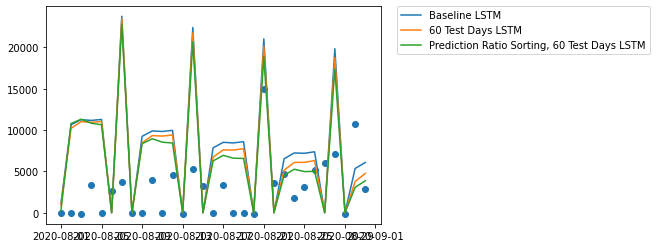

In [148]:
plt.scatter(labels, y_true)
for name, pred_df in predictions.items():
    y_pred_df = pred_df[(pred_df['Date'] >= start_date) & (pred_df['Date'] <= end_date)]
    y_pred_df["GeoID"] = np.where(y_pred_df["RegionName"].isnull(),
                                      y_pred_df["CountryName"],
                                      y_pred_df["CountryName"] + ' / ' + y_pred_df["RegionName"])
    y_pred = y_pred_df[(y_pred_df.GeoID == geo_id)]
    plt.plot(labels, y_pred.PredictedDailyNewCases.values, label=name)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Calculate MSE

In [151]:
from sklearn.metrics import mean_squared_error
for name, pred_df in predictions.items():
    y_pred_df = pred_df[(pred_df['Date'] >= start_date) & (pred_df['Date'] <= end_date)]
    y_pred_df["GeoID"] = np.where(y_pred_df["RegionName"].isnull(),
                                      y_pred_df["CountryName"],
                                      y_pred_df["CountryName"] + ' / ' + y_pred_df["RegionName"])
    y_pred = y_pred_df[(y_pred_df.GeoID == geo_id)]
    y_pred_values = y_pred.PredictedDailyNewCases.values
    mse = mean_squared_error(y_true, y_pred_values)
    print(f"{name}: {mse}") 

Baseline LSTM: 63713727.40025956
60 Test Days LSTM: 57361322.01903211
Prediction Ratio Sorting, 60 Test Days LSTM: 51917998.18420806
